In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import dataset_led

# The designated height and width of a image is fed into CNN
_IMG_HEIGHT = 64
_IMG_WIDTH = 64

# Data pipeline parameters
_BATCH_SIZE = 32
_EPOCHS = 20


def preprocess(img, label):
    """ Perform data preprocess including image transformation and label convertion
    Args:
        img: Image in tensor to be transformed
        label: Label in scalar to be converted
    Returns:
        A tulple of transformed image and converted label
    """
    # Resize to designated size so NN can process
    resized_img = tf.image.resize(img, [_IMG_HEIGHT, _IMG_WIDTH])
    # Normalize to 0 ~ 1
    normalized_img = resized_img / 255.0 
    # Convert 0-based label to one-hot format
    one_hot_label = tf.one_hot(label, depth=8)
    return normalized_img, one_hot_label


def create_dataset(ds):
    """ Create dataset applied needed process and transformation
    Args:
        ds: tf.data.dataset to be processed
    Returns:
        A tuple of processed dataset and the amount of dataset
    """
    # Get the size of the dataset
    n_samples = sum([1 for x in ds])
    return ds.map(preprocess).shuffle(n_samples*2).repeat().batch(_BATCH_SIZE), n_samples


# Get TFdataset by helper function
train_dataset, dev_dataset, test_dataset = dataset_led.load_data_tfdataset()

# Apply the data transformation to corresponding dataset, note that test dataset doesn't need to repeat
train_dataset, n_train_dataset= create_dataset(train_dataset)
dev_dataset, n_dev_dataset = create_dataset(dev_dataset)
test_dataset = test_dataset.map(preprocess).batch(_BATCH_SIZE)

TFRecords files already exist. Exiting without re-creating them.


In [2]:
def show_batch(image_batch, label_batch):
    """ Display a batch of images and its labels
    Args:
        images_batch: List of images in Tensors
        label_batch: List of true labels in Tensors
        predict_labels_batch: list of predicted labels in Tensors
    Returns:
        None
    """
    plt.figure(figsize=(20,20))
    for i, (image, label) in enumerate(zip(image_batch, label_batch)):
        img = tf.keras.preprocessing.image.array_to_img(image)
        plt.subplot(6,6,i+1)
        plt.imshow(img)
        plt.title(str(label.numpy()))
    plt.show()

    
# # Scripts for examing content of variable, comment out...
# for image_batch, label_batch in train_dataset.take(1):
#     print(image_batch.shape, label_batch.shape)
#     print(label_batch.numpy()[0])
#     print(image_batch.numpy()[0])

# image_batch, label_batch = next(iter(train_dataset))
# show_batch(image_batch, label_batch)

In [3]:
def create_model():
    """ Create the NN Keras model in sequential way
    Args:
        None
    Returns:
        The structure of the model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    return model

# Establish the model, which is a simple neural network with one hidden layer
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                786496    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 787,016
Trainable params: 787,016
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Compile the model and set the corresponding parameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Train and validate the model
model_details = model.fit(x=train_dataset,
                    epochs=_EPOCHS,
                    steps_per_epoch = n_train_dataset // _BATCH_SIZE,
                    validation_data = dev_dataset,
                    validation_steps = n_dev_dataset // _BATCH_SIZE)

# Save model into disk for further use
model.save('final_model.h5')

Train for 68 steps, validate for 14 steps
Epoch 1/40
68/68 [==============================] - 1s 18ms/step - loss: 1.8246 - categorical_accuracy: 0.3741 - val_loss: 1.5539 - val_categorical_accuracy: 0.5246
Epoch 2/40
68/68 [==============================] - 1s 11ms/step - loss: 1.3839 - categorical_accuracy: 0.5864 - val_loss: 1.2485 - val_categorical_accuracy: 0.5848
Epoch 3/40
68/68 [==============================] - 1s 11ms/step - loss: 1.1198 - categorical_accuracy: 0.7394 - val_loss: 0.9892 - val_categorical_accuracy: 0.8237
Epoch 4/40
68/68 [==============================] - 1s 11ms/step - loss: 0.8989 - categorical_accuracy: 0.8768 - val_loss: 0.8307 - val_categorical_accuracy: 0.9107
Epoch 5/40
68/68 [==============================] - 1s 11ms/step - loss: 0.7298 - categorical_accuracy: 0.9389 - val_loss: 0.6836 - val_categorical_accuracy: 0.9598
Epoch 6/40
68/68 [==============================] - 1s 11ms/step - loss: 0.5951 - categorical_accuracy: 0.9706 - val_loss: 0.5532 - v

In [5]:
# Evaluate the test dataset and get the corresponding accuracy
scores = model.evaluate(test_dataset, steps=None)
print("Test Dataset Accuracy: %.2f%%" % (scores[1]*100))

15/15 [==============================] - 0s 12ms/step - loss: 0.0181 - categorical_accuracy: 1.0000
Test Dataset Accuracy: 100.00%


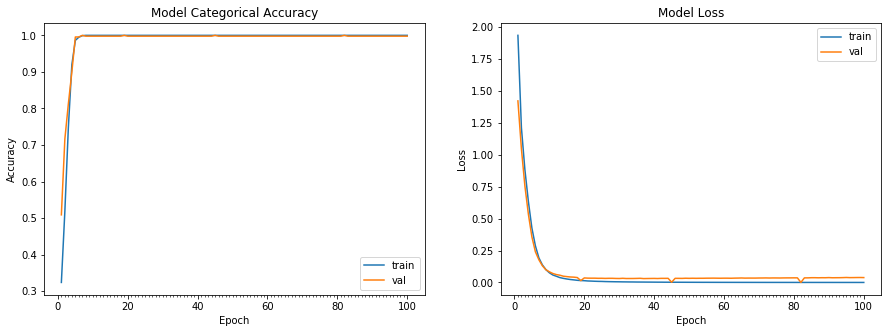

In [6]:
import numpy as np

def plot_model(model_details):
    """ Plot the training history to graph
    Args:
        model_details: The historical data of training and validation
    Returns:
        None
    """
    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['categorical_accuracy'])+1),model_details.history['categorical_accuracy'])
    axs[0].plot(range(1,len(model_details.history['val_categorical_accuracy'])+1),model_details.history['val_categorical_accuracy'])
    axs[0].set_title('Model Categorical Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['categorical_accuracy'])+1),len(model_details.history['categorical_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

# Visualize the training accuracy and loss
plot_model(model_details)